## Exercises

These are a few suggestions for exercises that may help improve your skills with TensorFlow. It is important to get hands-on experience with TensorFlow in order to learn how to use it properly.

You may want to backup this Notebook before making any changes.

* Change the learning-rate for the optimizer.
* Change the optimizer to e.g. `AdagradOptimizer` or `AdamOptimizer`.
* Change the batch-size to e.g. 1 or 1000.
* How do these changes affect the performance?
* Do you think these changes will have the same effect (if any) on other classification problems and mathematical models?
* Do you get the exact same results if you run the Notebook multiple times without changing any parameters? Why or why not?
* Change the function `plot_example_errors()` so it also prints the `logits` and `y_pred` values for the mis-classified examples.
* Use `sparse_softmax_cross_entropy_with_logits` instead of `softmax_cross_entropy_with_logits`. This may require several changes to multiple places in the source-code. Discuss the advantages and disadvantages of using the two methods.
* Remake the program yourself without looking too much at this source-code.
* Explain to a friend how the program works.

In [1]:
# %load 01_Simple_Linear_Model.py
from __future__ import print_function
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
from sklearn.metrics import confusion_matrix

%matplotlib inline

print("Tensorflow Version", tf.__version__)

Tensorflow Version 1.4.0


In [2]:
from tensorflow.examples.tutorials.mnist import input_data
data = input_data.read_data_sets("data/MNIST/", one_hot=True)


print("Size of:")
print("- Training-set:\t\t{}".format(len(data.train.labels)))
print("- Test-set:\t\t{}".format(len(data.test.labels)))
print("- Validation-set:\t{}".format(len(data.validation.labels)))


print("Example labels (1-hot)\n", data.test.labels[0:5, :])

data.test.cls = data.test.labels.argmax(axis=1)
print("Example labels (scalar)\n", data.test.cls[0:5])

Extracting data/MNIST/train-images-idx3-ubyte.gz
Extracting data/MNIST/train-labels-idx1-ubyte.gz
Extracting data/MNIST/t10k-images-idx3-ubyte.gz
Extracting data/MNIST/t10k-labels-idx1-ubyte.gz
Size of:
- Training-set:		55000
- Test-set:		10000
- Validation-set:	5000
Example labels (1-hot)
 [[ 0.  0.  0.  0.  0.  0.  0.  1.  0.  0.]
 [ 0.  0.  1.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  1.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 1.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  1.  0.  0.  0.  0.  0.]]
Example labels (scalar)
 [7 2 1 0 4]


In [3]:
batch_size = 100
img_size = 28
img_size_flat = img_size * img_size
img_shape = (img_size, img_size)
num_classes = 10

In [4]:
def plot_images(images, cls_true, cls_pred=None):
    assert len(images) == len(cls_true) == 9
    
    # Create figure with 3x3 sub-plots.
    fig, axes = plt.subplots(3, 3)
    fig.subplots_adjust(hspace=0.3, wspace=0.3)

    for i, ax in enumerate(axes.flat):
        # Plot image.
        ax.imshow(images[i].reshape(img_shape), cmap='binary')

        # Show true and predicted classes.
        if cls_pred is None:
            xlabel = "True: {0}".format(cls_true[i])
        else:
            xlabel = "True: {0}, Pred: {1}".format(cls_true[i], cls_pred[i])

        ax.set_xlabel(xlabel)
        
        # Remove ticks from the plot.
        ax.set_xticks([])
        ax.set_yticks([])

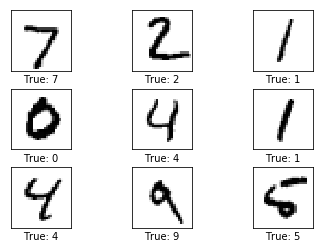

In [5]:
images = data.test.images[0:9]
cls_true = data.test.cls[0:9]
plot_images(images=images, cls_true=cls_true)

In [41]:
def create_graph(lr=0.5, optimizer="svd"):
    ## Input Placeholders
    #
    x = tf.placeholder(tf.float32, [None, img_size_flat])
    y_true = tf.placeholder(tf.float32, [None, num_classes])
    y_true_cls = tf.placeholder(tf.int64, [None])


    ## Model Parameters
    #
    weights = tf.Variable(tf.zeros([img_size_flat, num_classes]))
    biases = tf.Variable(tf.zeros([num_classes]))

    ## Model
    logits = tf.matmul(x, weights) + biases
    ## Output
    y_pred = tf.nn.softmax(logits)
    y_pred_cls = tf.argmax(y_pred, axis=1)

    ## Loss
    cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits=logits,
                                                            labels=y_true)
    cost = tf.reduce_mean(cross_entropy)

    ## Optimizer
    if optimizer == "adagrad":
        optimizer = tf.train.AdagradOptimizer(learning_rate=lr).minimize(cost)
    elif optimizer == 'adam':
        optimizer = tf.train.AdamOptimizer(learning_rate=lr).minimize(cost)
    else:
        optimizer = tf.train.GradientDescentOptimizer(learning_rate=lr).minimize(cost)
        

    ## Performance
    correct_prediction = tf.equal(y_pred_cls, y_true_cls)
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
    
    return x, y_true, y_true_cls, y_pred, weights, biases, y_pred_cls, optimizer, correct_prediction, accuracy

In [42]:
x, y_true, y_true_cls, y_pred, weights, biases, y_pred_cls, optimizer, correct_prediction, accuracy = create_graph()

In [43]:
## Initialize variables
session = tf.Session()
session.run(tf.global_variables_initializer())

In [44]:
## funtion to run a trainning epochs
def optimize(num_iterations, batch_size=100):
    for i in range(num_iterations):
        # Get a batch of training examples.
        # x_batch now holds a batch of images and
        # y_true_batch are the true labels for those images.
        x_batch, y_true_batch = data.train.next_batch(batch_size)
        
        # Put the batch into a dict with the proper names
        # for placeholder variables in the TensorFlow graph.
        # Note that the placeholder for y_true_cls is not set
        # because it is not used during training.
        feed_dict_train = {x: x_batch,
                           y_true: y_true_batch}

        # Run the optimizer using this batch of training data.
        # TensorFlow assigns the variables in feed_dict_train
        # to the placeholder variables and then runs the optimizer.
        session.run(optimizer, feed_dict=feed_dict_train)

In [45]:
feed_dict_test = {x: data.test.images,
                  y_true: data.test.labels,
                  y_true_cls: data.test.cls}

In [46]:
def print_accuracy():
    # Use TensorFlow to compute the accuracy.
    acc = session.run(accuracy, feed_dict=feed_dict_test)
    
    # Print the accuracy.
    print("Accuracy on test-set: {0:.1%}".format(acc))

In [47]:
def print_confusion_matrix():
    # Get the true classifications for the test-set.
    cls_true = data.test.cls
    
    # Get the predicted classifications for the test-set.
    cls_pred = session.run(y_pred_cls, feed_dict=feed_dict_test)

    # Get the confusion matrix using sklearn.
    cm = confusion_matrix(y_true=cls_true,
                          y_pred=cls_pred)

    # Print the confusion matrix as text.
    print(cm)

    # Plot the confusion matrix as an image.
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)

    # Make various adjustments to the plot.
    plt.tight_layout()
    plt.colorbar()
    tick_marks = np.arange(num_classes)
    plt.xticks(tick_marks, range(num_classes))
    plt.yticks(tick_marks, range(num_classes))
    plt.xlabel('Predicted')
    plt.ylabel('True')

In [48]:
def plot_example_errors():
    # Use TensorFlow to get a list of boolean values
    # whether each test-image has been correctly classified,
    # and a list for the predicted class of each image.
    correct, cls_pred = session.run([correct_prediction, y_pred_cls],
                                    feed_dict=feed_dict_test)

    # Negate the boolean array.
    incorrect = (correct == False)
    
    # Get the images from the test-set that have been
    # incorrectly classified.
    images = data.test.images[incorrect]
    
    # Get the predicted classes for those images.
    cls_pred = cls_pred[incorrect]

    # Get the true classes for those images.
    cls_true = data.test.cls[incorrect]
    
    # Plot the first 9 images.
    plot_images(images=images[0:9],
                cls_true=cls_true[0:9],
                cls_pred=cls_pred[0:9])

In [49]:
def plot_weights():
    # Get the values for the weights from the TensorFlow variable.
    w = session.run(weights)
    
    # Get the lowest and highest values for the weights.
    # This is used to correct the colour intensity across
    # the images so they can be compared with each other.
    w_min = np.min(w)
    w_max = np.max(w)

    # Create figure with 3x4 sub-plots,
    # where the last 2 sub-plots are unused.
    fig, axes = plt.subplots(3, 4)
    fig.subplots_adjust(hspace=0.3, wspace=0.3)

    for i, ax in enumerate(axes.flat):
        # Only use the weights for the first 10 sub-plots.
        if i<10:
            # Get the weights for the i'th digit and reshape it.
            # Note that w.shape == (img_size_flat, 10)
            image = w[:, i].reshape(img_shape)

            # Set the label for the sub-plot.
            ax.set_xlabel("Weights: {0}".format(i))

            # Plot the image.
            ax.imshow(image, vmin=w_min, vmax=w_max, cmap='seismic')

        # Remove ticks from each sub-plot.
        ax.set_xticks([])
        ax.set_yticks([])

Performance before any optimization
Accuracy on test-set: 9.8%


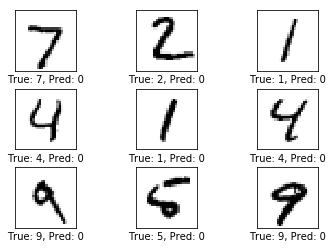

In [50]:
print("Performance before any optimization")
print_accuracy()

plot_example_errors()

Performance after 1 optimization iteration
Accuracy on test-set: 27.6%


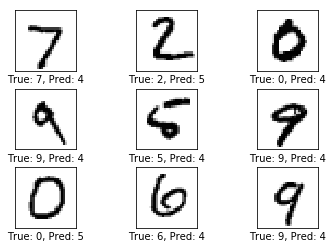

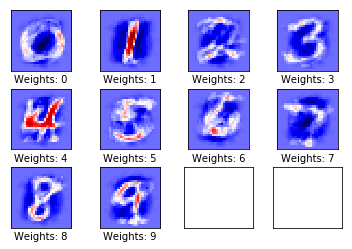

In [51]:
optimize(num_iterations=1)
print("Performance after 1 optimization iteration")
print_accuracy()
plot_example_errors()
plot_weights()

Performance after 10 optimization iterations
Accuracy on test-set: 69.2%


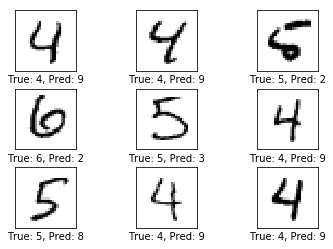

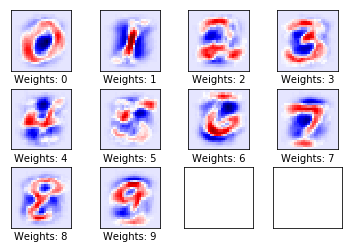

In [52]:
optimize(num_iterations=9)
print("Performance after 10 optimization iterations")
print_accuracy()
plot_example_errors()
plot_weights()

Performance after 1000 optimization iterations
Accuracy on test-set: 91.8%


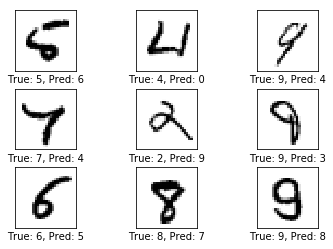

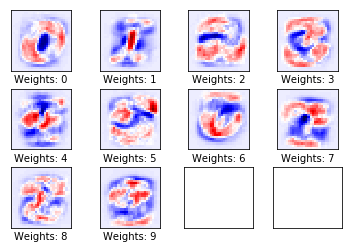

In [53]:
optimize(num_iterations=990)
print("Performance after 1000 optimization iterations")
print_accuracy()
plot_example_errors()
plot_weights()

[[ 964    0    0    2    0    4    7    1    2    0]
 [   0 1108    2    2    0    2    4    2   15    0]
 [   9   10  879   36   10    3   15    8   51   11]
 [   4    0    9  951    0   15    3    7   13    8]
 [   2    1    2    2  901    0   13    2    8   51]
 [  10    4    2   55    9  750   17    4   33    8]
 [  12    3    3    2   10   12  910    2    4    0]
 [   3    9   18   13    6    1    0  932    3   43]
 [   7    9    2   41    9   22    8    8  859    9]
 [  11    6    2   15   25    6    0    8    7  929]]


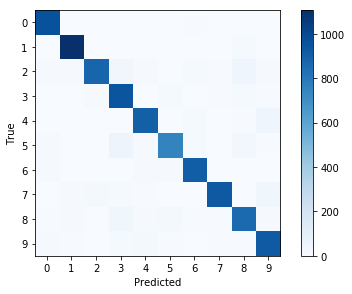

In [54]:
print_confusion_matrix()

In [55]:
session.close()

In [21]:
import itertools

In [22]:
## Initialize variables

batch_sizes = [10, 50, 100, 150]
learning_rates = [0.5, 0.05, 0.005]
optimizers = ['adam', 'adagrad', 'svd']

todo = [batch_sizes, learning_rates, optimizers]

for idx, itr in enumerate(itertools.product(*todo)):
    print("Trial {}".format(idx))
    
    batch_size, lr, opt = itr

    x, y_true, y_true_cls, y_pred, weights, biases, y_pred_cls, optimizer, correct_prediction, accuracy = create_graph(lr, opt)
    session = tf.Session()
    session.run(tf.global_variables_initializer())
    print("Performance 0")
    print_accuracy()
    optimize(num_iterations=1000, batch_size=batch_size)

    print("Trial restuls")
    print_accuracy()
    session.close()

Trial 0
Performance 0


InvalidArgumentError: You must feed a value for placeholder tensor 'Placeholder_5' with dtype int64 and shape [?]
	 [[Node: Placeholder_5 = Placeholder[dtype=DT_INT64, shape=[?], _device="/job:localhost/replica:0/task:0/device:CPU:0"]()]]

Caused by op u'Placeholder_5', defined at:
  File "/Users/pedro/anaconda/envs/tf_tutorials/lib/python2.7/runpy.py", line 174, in _run_module_as_main
    "__main__", fname, loader, pkg_name)
  File "/Users/pedro/anaconda/envs/tf_tutorials/lib/python2.7/runpy.py", line 72, in _run_code
    exec code in run_globals
  File "/Users/pedro/anaconda/envs/tf_tutorials/lib/python2.7/site-packages/ipykernel/__main__.py", line 3, in <module>
    app.launch_new_instance()
  File "/Users/pedro/anaconda/envs/tf_tutorials/lib/python2.7/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/Users/pedro/anaconda/envs/tf_tutorials/lib/python2.7/site-packages/ipykernel/kernelapp.py", line 477, in start
    ioloop.IOLoop.instance().start()
  File "/Users/pedro/anaconda/envs/tf_tutorials/lib/python2.7/site-packages/zmq/eventloop/ioloop.py", line 177, in start
    super(ZMQIOLoop, self).start()
  File "/Users/pedro/anaconda/envs/tf_tutorials/lib/python2.7/site-packages/tornado/ioloop.py", line 888, in start
    handler_func(fd_obj, events)
  File "/Users/pedro/anaconda/envs/tf_tutorials/lib/python2.7/site-packages/tornado/stack_context.py", line 277, in null_wrapper
    return fn(*args, **kwargs)
  File "/Users/pedro/anaconda/envs/tf_tutorials/lib/python2.7/site-packages/zmq/eventloop/zmqstream.py", line 440, in _handle_events
    self._handle_recv()
  File "/Users/pedro/anaconda/envs/tf_tutorials/lib/python2.7/site-packages/zmq/eventloop/zmqstream.py", line 472, in _handle_recv
    self._run_callback(callback, msg)
  File "/Users/pedro/anaconda/envs/tf_tutorials/lib/python2.7/site-packages/zmq/eventloop/zmqstream.py", line 414, in _run_callback
    callback(*args, **kwargs)
  File "/Users/pedro/anaconda/envs/tf_tutorials/lib/python2.7/site-packages/tornado/stack_context.py", line 277, in null_wrapper
    return fn(*args, **kwargs)
  File "/Users/pedro/anaconda/envs/tf_tutorials/lib/python2.7/site-packages/ipykernel/kernelbase.py", line 283, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "/Users/pedro/anaconda/envs/tf_tutorials/lib/python2.7/site-packages/ipykernel/kernelbase.py", line 235, in dispatch_shell
    handler(stream, idents, msg)
  File "/Users/pedro/anaconda/envs/tf_tutorials/lib/python2.7/site-packages/ipykernel/kernelbase.py", line 399, in execute_request
    user_expressions, allow_stdin)
  File "/Users/pedro/anaconda/envs/tf_tutorials/lib/python2.7/site-packages/ipykernel/ipkernel.py", line 196, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/Users/pedro/anaconda/envs/tf_tutorials/lib/python2.7/site-packages/ipykernel/zmqshell.py", line 533, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/Users/pedro/anaconda/envs/tf_tutorials/lib/python2.7/site-packages/IPython/core/interactiveshell.py", line 2717, in run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "/Users/pedro/anaconda/envs/tf_tutorials/lib/python2.7/site-packages/IPython/core/interactiveshell.py", line 2821, in run_ast_nodes
    if self.run_code(code, result):
  File "/Users/pedro/anaconda/envs/tf_tutorials/lib/python2.7/site-packages/IPython/core/interactiveshell.py", line 2881, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-22-6de31fecbde3>", line 14, in <module>
    x, y_true, y_true_cls, y_pred, weights, biases, y_pred_cls, optimizer, correct_prediction, accuracy = create_graph(lr, opt)
  File "<ipython-input-6-26d8d3412fae>", line 6, in create_graph
    y_true_cls = tf.placeholder(tf.int64, [None])
  File "/Users/pedro/anaconda/envs/tf_tutorials/lib/python2.7/site-packages/tensorflow/python/ops/array_ops.py", line 1599, in placeholder
    return gen_array_ops._placeholder(dtype=dtype, shape=shape, name=name)
  File "/Users/pedro/anaconda/envs/tf_tutorials/lib/python2.7/site-packages/tensorflow/python/ops/gen_array_ops.py", line 3091, in _placeholder
    "Placeholder", dtype=dtype, shape=shape, name=name)
  File "/Users/pedro/anaconda/envs/tf_tutorials/lib/python2.7/site-packages/tensorflow/python/framework/op_def_library.py", line 787, in _apply_op_helper
    op_def=op_def)
  File "/Users/pedro/anaconda/envs/tf_tutorials/lib/python2.7/site-packages/tensorflow/python/framework/ops.py", line 2956, in create_op
    op_def=op_def)
  File "/Users/pedro/anaconda/envs/tf_tutorials/lib/python2.7/site-packages/tensorflow/python/framework/ops.py", line 1470, in __init__
    self._traceback = self._graph._extract_stack()  # pylint: disable=protected-access

InvalidArgumentError (see above for traceback): You must feed a value for placeholder tensor 'Placeholder_5' with dtype int64 and shape [?]
	 [[Node: Placeholder_5 = Placeholder[dtype=DT_INT64, shape=[?], _device="/job:localhost/replica:0/task:0/device:CPU:0"]()]]
